# Getting Started with bluebonnet

## Quick start

In your command line, run this:

```bash
pip install bluebonnet
```

Pip will automatically download the project dependencies and make bluebonnet available in your python environment.

Now, in your script or notebook, let's import what we need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from bluebonnet.flow import IdealReservoir
from bluebonnet.forecast import Bounds, ForecasterOnePhase
from bluebonnet.plotting import (
    plot_pseudopressure,
    plot_recovery_factor,
    plot_recovery_rate,
)


## Reservoir

First we need fluid properties. For absolute starters, let's say we have an ideal gas. Our initial reservoir pressure is 9,000 psi, and we our frac-face pressure is 1,000 psi. Then, we build our reservoir:

In [2]:
initial_pressure = 9000
frac_face_pressure = 1000
num_points = 50
reservoir = IdealReservoir(num_points, frac_face_pressure, initial_pressure)

Then, simulate the reservoir drawdown:

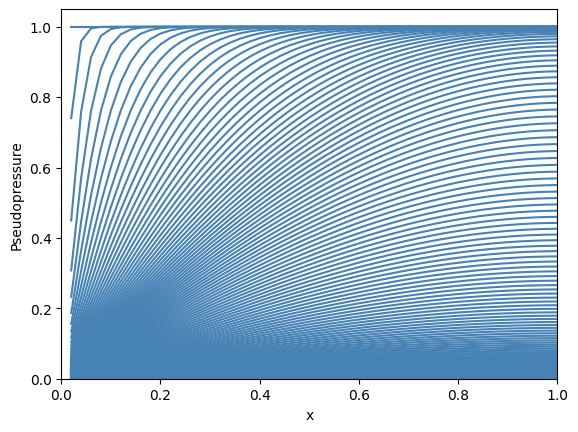

In [3]:
num_time = 10_000
time_end = 6
time = np.linspace(0, np.sqrt(time_end), num_time) ** 2
reservoir.simulate(time)
fig, ax = plt.subplots()
plot_pseudopressure(reservoir, every=50, ax=ax);

And calculate the recovery rate and recovery factor over time:

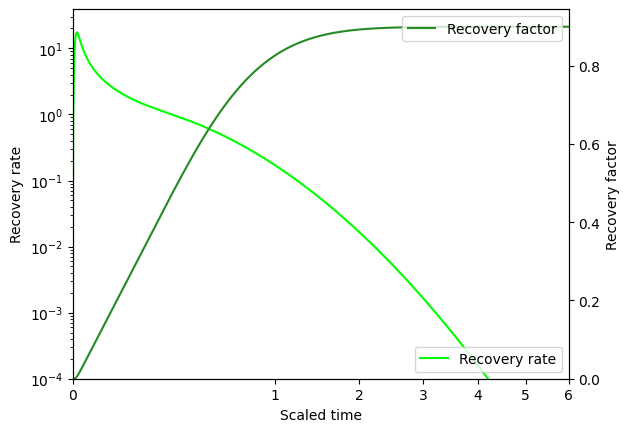

In [4]:
rf = reservoir.recovery_factor()
fig, ax = plt.subplots()
plot_recovery_rate(reservoir, ax, plot_kwargs={"color": "lime"})
ax.legend(loc="lower right")
ax2 = ax.twinx()
plot_recovery_factor(reservoir, ax2, plot_kwargs={"color": "forestgreen"})
ax2.legend(loc="upper right");

## Fit and forecast a well

Now, to fit and forecast production from our well. Let's use a synthetic well here:

In [49]:
fake_ooip = 100
fake_tau = 1.5
time_on_production = time[: len(time) // 2] * fake_tau
randomness = np.maximum(
    0, np.random.default_rng(42).normal(0, 0.02, size=len(time_on_production))
).cumsum()
fake_cum = rf[: len(time) // 2] * fake_ooip + randomness

And then use `ForecasterOnePhase` to match its production:

The fitted OOIP is 146.25, and it should be over 100 (because all the randomness is positive)
The fitted tau is 1.85, and it should be near 1.5


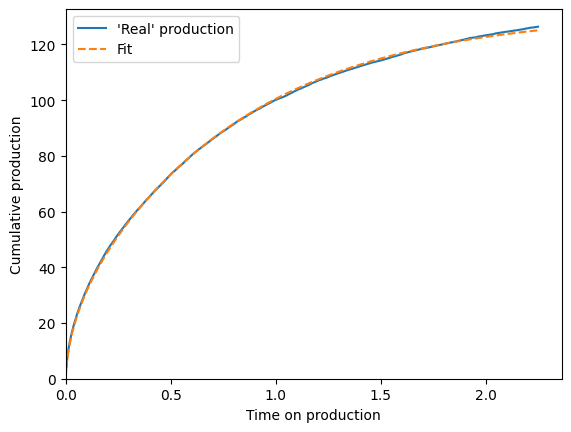

In [51]:
rf_func = interp1d(time, rf, bounds_error=False, fill_value=(0, rf[-1]))
bounds = Bounds(M=(0, 500), tau=(0.1, 25))
scaling_curve = ForecasterOnePhase(rf_func, bounds)
scaling_curve.fit(time_on_production, fake_cum)
print(
    f"The fitted OOIP is {scaling_curve.M_:.2f}, and it should be over {fake_ooip} "
    "(because all the randomness is positive)\n"
    f"The fitted tau is {scaling_curve.tau_:.2f}, and it should be near {fake_tau}"
)


cum_bestfit = scaling_curve.forecast_cum(time_on_production)

fig, ax = plt.subplots()
ax.plot(time_on_production, fake_cum, label="'Real' production")
ax.plot(time_on_production, cum_bestfit, "--", label="Fit")
ax.legend()
ax.set(
    xlim=(0, None),
    ylim=(0, None),
    xlabel="Time on production",
    ylabel="Cumulative production",
);

Then, forecast the future:

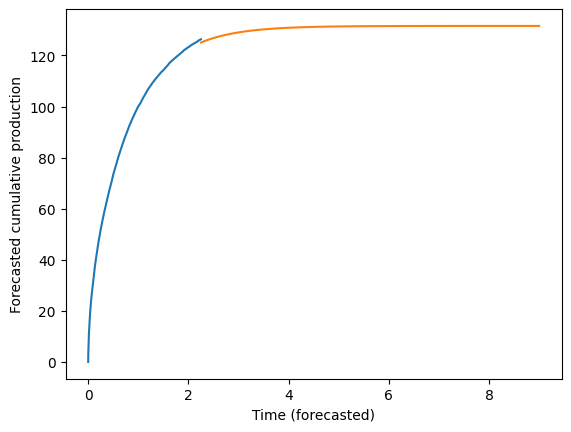

In [58]:
time_forecast = np.linspace(max(time_on_production), 9, 12 * 9)
forecast_cum = scaling_curve.forecast_cum(time_forecast)
fig, ax = plt.subplots()
ax.plot(time_on_production, fake_cum, label="'Real' production")
ax.plot(time_forecast, forecast_cum, scalex="squareroot")
ax.set(
    xlabel="Time (forecasted)",
    ylabel="Forecasted cumulative production",
);